<a href="https://colab.research.google.com/github/whitechocobread/Ai-project/blob/main/3%EC%A3%BC%EC%B0%A8/Naver_Movie_Review_Sentiment_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **네이버 영화 리뷰 감성 분류하기**

# **네이버 영화 리뷰 데이터에 대한 이해와 전처리**

In [1]:
!pip install konlpy


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.4/19.4 MB 60.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 465.3/465.3 kB 41.7 MB/s eta 0:00:00


In [2]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import urllib.request
from konlpy.tag import Okt
from tqdm import tqdm
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# **1) 데이터 로드하기**

In [3]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/e9t/nsmc/master/ratings_train.txt", filename="ratings_train.txt")
urllib.request.urlretrieve("https://raw.githubusercontent.com/e9t/nsmc/master/ratings_test.txt", filename="ratings_test.txt")

('ratings_test.txt', <http.client.HTTPMessage at 0x7ade8b14ab00>)

In [4]:
train_data = pd.read_table('ratings_train.txt')
test_data = pd.read_table('ratings_test.txt')

In [5]:
train_data[:5] # 상위 5개 출력


,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


# **2) 데이터 정제하기**

훈련 데이터에 대해서 텍스트 전처리

In [6]:
# 데이터의 중복 유무 document 열과 label 열의 중복을 제외한 값의 개수/
train_data['document'].nunique(), train_data['label'].nunique()

(146182, 2)

In [7]:
#document 열의 중복 제거
train_data.drop_duplicates(subset=['document'], inplace=True)

In [8]:
print('총 샘플의 수 :',len(train_data))

총 샘플의 수 : 146183


<Axes: >

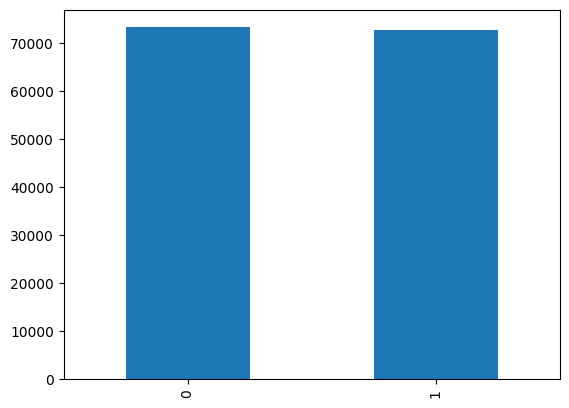

In [9]:
train_data['label'].value_counts().plot(kind = 'bar')

In [10]:

print(train_data.groupby('label').size().reset_index(name = 'count'))

   label  count
0      0  73342
1      1  72841


In [11]:
#리뷰 중에 Null값을 가진 샘플이 있는지 확인
print(train_data.isnull().values.any())

True


In [12]:
print(train_data.isnull().sum())

id          0
document    1
label       0
dtype: int64


In [13]:
train_data.loc[train_data.document.isnull()]

,id,document,label
25857,2172111,NaN,1


In [14]:
train_data = train_data.dropna(how = 'any') # Null 값이 존재하는 행 제거
print(train_data.isnull().values.any()) # Null 값이 존재하는지 확인

False


In [15]:
print(len(train_data))

146182


데이터 전처리

In [16]:
#알파벳과 공백을 제외하고 모두 제거
eng_text = 'do!!! you expect... people~ to~ read~ the FAQ, etc. and actually accept hard~! atheism?@@'
print(re.sub(r'[^a-zA-Z ]', '', eng_text))


do you expect people to read the FAQ etc and actually accept hard atheism


한국어 데이터에 적용

In [17]:
# 한글과 공백을 제외하고 모두 제거
train_data['document'] = train_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
train_data[:5]

<ipython-input-17-4419b0600db1>:2: FutureWarning: The default value of regex will change from True to False in a future version.
  train_data['document'] = train_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")


,id,document,label
0,9976970,아 더빙 진짜 짜증나네요 목소리,0
1,3819312,흠포스터보고 초딩영화줄오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 솔직히 재미는 없다평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화스파이더맨에서 늙어보이기만 했던 커스틴 던...,1


In [18]:
#네이버 영화 리뷰는 한글이 아니더라도 영어, 숫자, 특수문자로도 리뷰를 업로드할 수 있습니다. 다시 말해 기존에 한글이 없는 리뷰였다면 더 이상 아무런 값도 없는 빈(empty) 값이 되었을 것입니다
#Null 값이 존재하는지 확인
train_data['document'] = train_data['document'].str.replace('^ +', "") # white space 데이터를 empty value로 변경
train_data['document'].replace('', np.nan, inplace=True)
print(train_data.isnull().sum())

id            0
document    789
label         0
dtype: int64


<ipython-input-18-8818fdd6f555>:3: FutureWarning: The default value of regex will change from True to False in a future version.
  train_data['document'] = train_data['document'].str.replace('^ +', "") # white space 데이터를 empty value로 변경


In [19]:
train_data.loc[train_data.document.isnull()][:5]

,id,document,label
404,4221289,NaN,0
412,9509970,NaN,1
470,10147571,NaN,1
584,7117896,NaN,0
593,6478189,NaN,0


In [20]:
# 긍정 부정 일수있는 null값 제거
train_data = train_data.dropna(how = 'any')
print(len(train_data))

145393


데이터 전처리

In [21]:
test_data.drop_duplicates(subset = ['document'], inplace=True) # document 열에서 중복인 내용이 있다면 중복 제거
test_data['document'] = test_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","") # 정규 표현식 수행
test_data['document'] = test_data['document'].str.replace('^ +', "") # 공백은 empty 값으로 변경
test_data['document'].replace('', np.nan, inplace=True) # 공백은 Null 값으로 변경
test_data = test_data.dropna(how='any') # Null 값 제거
print('전처리 후 테스트용 샘플의 개수 :',len(test_data))

전처리 후 테스트용 샘플의 개수 : 48852


<ipython-input-21-c182d8fa0991>:2: FutureWarning: The default value of regex will change from True to False in a future version.
  test_data['document'] = test_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","") # 정규 표현식 수행
<ipython-input-21-c182d8fa0991>:3: FutureWarning: The default value of regex will change from True to False in a future version.
  test_data['document'] = test_data['document'].str.replace('^ +', "") # 공백은 empty 값으로 변경


# **3) 토큰화**

테스트 데이터에 대해서 텍스트 전처리

In [22]:
#불용어 제거
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

In [23]:
#불용어를 정의하고, 토큰화를 위한 형태소 분석기는 KoNLPy의 Okt를 사용
okt = Okt()# KoNLPy에서 제공하는 형태소 분석기
okt.morphs('와 이런 것도 영화라고 차라리 뮤직비디오를 만드는 게 나을 뻔', stem = True)

['오다', '이렇다', '것', '도', '영화', '라고', '차라리', '뮤직비디오', '를', '만들다', '게', '나다', '뻔']

In [24]:
X_train = []
for sentence in tqdm(train_data['document']):
    tokenized_sentence = okt.morphs(sentence, stem=True) # 토큰화
    stopwords_removed_sentence = [word for word in tokenized_sentence if not word in stopwords] # 불용어 제거
    X_train.append(stopwords_removed_sentence)

100%|██████████| 145393/145393 [07:56<00:00, 304.98it/s]


In [25]:
print(X_train[:3])


[['아', '더빙', '진짜', '짜증나다', '목소리'], ['흠', '포스터', '보고', '초딩', '영화', '줄', '오버', '연기', '조차', '가볍다', '않다'], ['너', '무재', '밓었', '다그', '래서', '보다', '추천', '다']]


In [26]:
#테스트 데이터 토큰
X_test = []
for sentence in tqdm(test_data['document']):
    tokenized_sentence = okt.morphs(sentence, stem=True) # 토큰화
    stopwords_removed_sentence = [word for word in tokenized_sentence if not word in stopwords] # 불용어 제거
    X_test.append(stopwords_removed_sentence)

100%|██████████| 48852/48852 [02:50<00:00, 286.73it/s]


# **4) 정수 인코딩**

기계가 텍스트를 숫자로 처리할 수 있도록 훈련 데이터와 테스트 데이터에 정수 인코딩을 수행

In [27]:
#단어 집합(vocaburary)만들기
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

In [28]:
#value error해결
df = pd.DataFrame.from_dict([tokenizer.word_index])
df

,영화,보다,을,없다,이다,있다,좋다,너무,다,정말,...,초코,대병소장,신해혁명,차이니즈,차후,ㅍㄹㄱ,섹귀들,찎었,디케이드,수간
0,1,2,3,4,5,6,7,8,9,10,...,43743,43744,43745,43746,43747,43748,43749,43750,43751,43752


각 정수는 전체 훈련 데이터에서 등장 빈도수가 높은 순서대로 부여되었기 때문에, 높은 정수가 부여된 단어들은 등장 빈도수가 매우 낮다는 것을 의미합니다. 여기서는 빈도수가 낮은 단어들은 자연어 처리에서 배제하고자 합니다.

In [29]:
#등장 빈도수가 3회 미만인 단어들이 이 데이터에서 얼만큼의 비중을 차지하는지 확인
threshold = 3
total_cnt = len(tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 43752
등장 빈도가 2번 이하인 희귀 단어의 수: 24337
단어 집합에서 희귀 단어의 비율: 55.62488571950996
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 1.8715872104872904


In [30]:
# 전체 단어 개수 중 빈도수 2이하인 단어는 제거.
# 0번 패딩 토큰을 고려하여 + 1
vocab_size = total_cnt - rare_cnt + 1
print('단어 집합의 크기 :',vocab_size)

단어 집합의 크기 : 19416


In [31]:
#단어 집합의 크기는 19,416개이다. 이를 케라스 토크나이저의 인자로 넘겨주고 텍스트 시퀀스를 정수 시퀀스로 변환
tokenizer = Tokenizer(vocab_size)
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [32]:
print(X_train[:3])

[[50, 454, 16, 260, 659], [933, 457, 41, 602, 1, 214, 1449, 24, 961, 675, 19], [386, 2444, 2315, 5671, 2, 222, 9]]


In [33]:
#train_data에서 y_train과 y_test를 별도로 저장
y_train = np.array(train_data['label'])
y_test = np.array(test_data['label'])

# **5) 빈 샘플(empty samples) 제거**

전체 데이터에서 빈도수가 낮은 단어가 삭제되었다는 것은 빈도수가 낮은 단어만으로 구성되었던 샘플들은 빈(empty) 샘플이 되었다는 것을 의미합니다. 빈 샘플들은 어떤 레이블이 붙어있던 의미가 없으므로 빈 샘플들을 제거해주는 작업 진행

In [34]:
#길이가 0인 샘플들의 인덱스를 받아오기
drop_train = [index for index, sentence in enumerate(X_train) if len(sentence) < 1]

In [35]:
# 빈 샘플들을 제거
X_train = np.delete(X_train, drop_train, axis=0)
y_train = np.delete(y_train, drop_train, axis=0)
print(len(X_train))
print(len(y_train))


145162
145162


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:5071: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asarray(arr)


# **6) 패딩**

서로 다른 길이의 샘플들의 길이를 동일하게 맞춰주는 패딩 작업을 진행

리뷰의 최대 길이 : 69
리뷰의 평균 길이 : 10.812485361182679


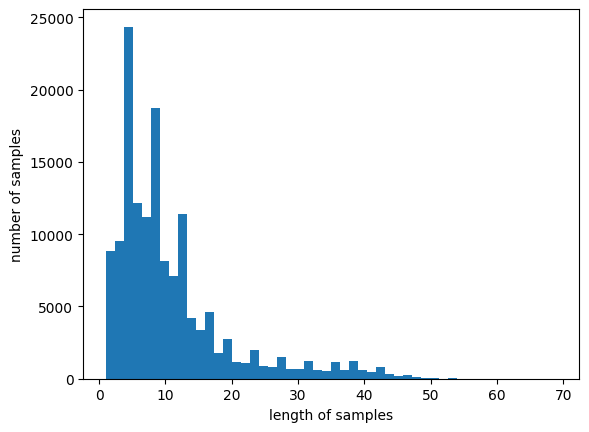

In [36]:
#전체 데이터에서 가장 길이가 긴 리뷰와 전체 데이터의 길이 분포
print('리뷰의 최대 길이 :',max(len(review) for review in X_train))
print('리뷰의 평균 길이 :',sum(map(len, X_train))/len(X_train))
plt.hist([len(review) for review in X_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

가장 긴 리뷰의 길이는 69이며, 그래프를 봤을 때 전체 데이터의 길이 분포는 대체적으로 약 11내외의 길이를 가지는 것을 볼 수 있습니다. 모델이 처리할 수 있도록 X_train과 X_test의 모든 샘플의 길이를 특정 길이로 동일하게 맞춰줄 필요가 있습니다. 특정 길이 변수를 max_len으로 정합니다. 대부분의 리뷰가 내용이 잘리지 않도록 할 수 있는 최적의 max_len의 값은 몇일까요? 전체 샘플 중 길이가 max_len 이하인 샘플의 비율이 몇 %인지 확인하는 함수를 만듭니다.

In [37]:
def below_threshold_len(max_len, nested_list):
  count = 0
  for sentence in nested_list:
    if(len(sentence) <= max_len):
        count = count + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (count / len(nested_list))*100))

 94%의 리뷰가 30이하의 길이를 가지는 것을 확인

In [38]:
max_len = 30
below_threshold_len(max_len, X_train)

전체 샘플 중 길이가 30 이하인 샘플의 비율: 94.31944999380003


In [39]:
X_train = pad_sequences(X_train, maxlen=max_len)
X_test = pad_sequences(X_test, maxlen=max_len)

# **2. LSTM으로 네이버 영화 리뷰 감성 분류하기**

**EarlyStopping**(monitor='val_loss', mode='min', verbose=1, patience=4)는 검증 데이터 손실(val_loss)이 증가하면, 과적합 징후므로 검증 데이터 손실이 4회 증가하면 정해진 에포크가 도달하지 못하였더라도 학습을 조기 종료(Early Stopping)한다는 의미입니다. ModelCheckpoint를 사용하여 검증 데이터의 정확도(val_acc)가 이전보다 좋아질 경우에만 모델을 저장합니다. validation_split=0.2을 사용하여 훈련 데이터의 20%를 검증 데이터로 분리해서 사용하고, 검증 데이터를 통해서 훈련이 적절히 되고 있는지 확인합니다. 검증 데이터는 기계가 훈련 데이터에 과적합되고 있지는 않은지 확인하기 위한 용도로 사용됩니다.

In [40]:
#모델: LSTM 사용
from tensorflow.keras.layers import Embedding, Dense, LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

embedding_dim = 100
hidden_units = 128

model = Sequential()
model.add(Embedding(vocab_size, embedding_dim))
model.add(LSTM(hidden_units))
model.add(Dense(1, activation='sigmoid'))

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(X_train, y_train, epochs=15, callbacks=[es, mc], batch_size=64, validation_split=0.2)


Epoch 1/15
1815/1815 [==============================] - ETA: 0s - loss: 0.4103 - acc: 0.8110
Epoch 1: val_acc improved from -inf to 0.83798, saving model to best_model.h5
1815/1815 [==============================] - 46s 21ms/step - loss: 0.4103 - acc: 0.8110 - val_loss: 0.3705 - val_acc: 0.8380
Epoch 2/15
   1/1815 [..............................] - ETA: 11s - loss: 0.2471 - acc: 0.8906

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1815/1815 [==============================] - ETA: 0s - loss: 0.3465 - acc: 0.8498
Epoch 2: val_acc improved from 0.83798 to 0.84359, saving model to best_model.h5
1815/1815 [==============================] - 11s 6ms/step - loss: 0.3465 - acc: 0.8498 - val_loss: 0.3532 - val_acc: 0.8436
Epoch 3/15
1815/1815 [==============================] - ETA: 0s - loss: 0.3198 - acc: 0.8636
Epoch 3: val_acc improved from 0.84359 to 0.85038, saving model to best_model.h5
1815/1815 [==============================] - 12s 7ms/step - loss: 0.3198 - acc: 0.8636 - val_loss: 0.3416 - val_acc: 0.8504
Epoch 4/15
1815/1815 [==============================] - ETA: 0s - loss: 0.2964 - acc: 0.8763
Epoch 4: val_acc improved from 0.85038 to 0.85454, saving model to best_model.h5
1815/1815 [==============================] - 10s 6ms/step - loss: 0.2964 - acc: 0.8763 - val_loss: 0.3371 - val_acc: 0.8545
Epoch 5/15
1815/1815 [==============================] - ETA: 0s - loss: 0.2764 - acc: 0.8868
Epoch 5: val_acc did not

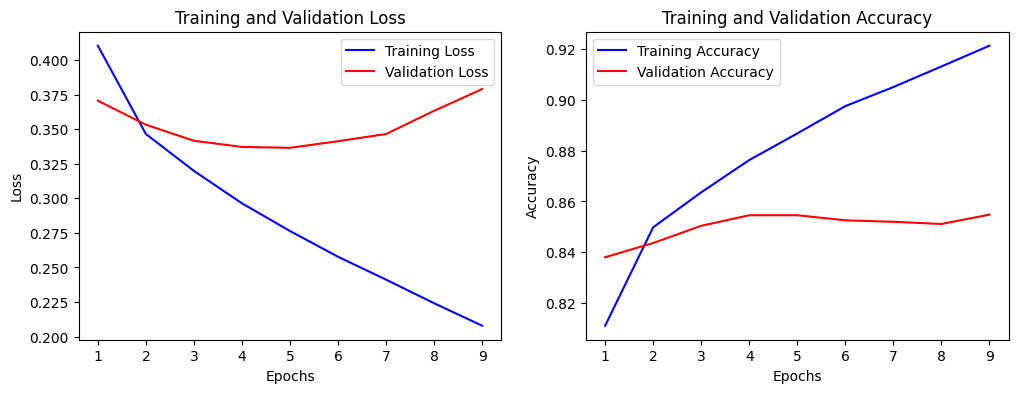

In [41]:
import matplotlib.pyplot as plt

# 훈련 손실 및 정확도
train_loss = history.history['loss']
train_acc = history.history['acc']

# 검증 손실 및 정확도
val_loss = history.history['val_loss']
val_acc = history.history['val_acc']

# 에포크 수
epochs = range(1, len(train_loss) + 1)

# 손실 그래프
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# 정확도 그래프
plt.subplot(1, 2, 2)
plt.plot(epochs, train_acc, 'b', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()




In [42]:
#정확도 측청
loaded_model = load_model('best_model.h5')
print("\n 테스트 정확도: %.4f" % (loaded_model.evaluate(X_test, y_test)[1]))

1527/1527 [==============================] - 5s 3ms/step - loss: 0.3928 - acc: 0.8483

 테스트 정확도: 0.8483


In [43]:
with open('tokenizer.pickle', 'wb') as handle:
     pickle.dump(tokenizer, handle)

with open('tokenizer.pickle', 'rb') as handle:
    tokenizer = pickle.load(handle)

# **EarlyStopping**을 안할경우

얼리 스톱을 비활성화하려면 다음과 같이 EarlyStopping 콜백을 생성할 때 patience 매개변수를 큰 값으로 설정한다. patience는 검증 손실이 얼마나 오랫동안 감소하지 않아야 중단할 것인지를 나타낸다. 큰 값으로 설정하면 얼리 스톱을 비활성화하는 것과 유사하게 작동합니다.

Epoch 1/15
1815/1815 [==============================] - 37s 19ms/step - loss: 0.4106 - acc: 0.8093 - val_loss: 0.3699 - val_acc: 0.8371
Epoch 2/15
1815/1815 [==============================] - 12s 7ms/step - loss: 0.3463 - acc: 0.8497 - val_loss: 0.3565 - val_acc: 0.8433
Epoch 3/15
1815/1815 [==============================] - 11s 6ms/step - loss: 0.3198 - acc: 0.8633 - val_loss: 0.3397 - val_acc: 0.8509
Epoch 4/15
1815/1815 [==============================] - 11s 6ms/step - loss: 0.2976 - acc: 0.8756 - val_loss: 0.3358 - val_acc: 0.8554
Epoch 5/15
1815/1815 [==============================] - 11s 6ms/step - loss: 0.2778 - acc: 0.8865 - val_loss: 0.3432 - val_acc: 0.8547
Epoch 6/15
1815/1815 [==============================] - 10s 6ms/step - loss: 0.2596 - acc: 0.8956 - val_loss: 0.3531 - val_acc: 0.8552
Epoch 7/15
1815/1815 [==============================] - 10s 5ms/step - loss: 0.2426 - acc: 0.9045 - val_loss: 0.3622 - val_acc: 0.8491
Epoch 8/15
1815/1815 [==============================] 

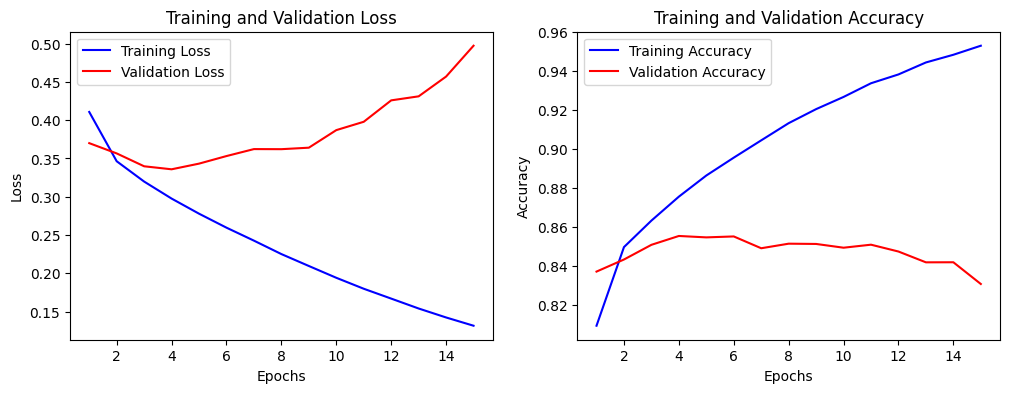

In [49]:
from tensorflow.keras.layers import Embedding, Dense, LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping

# 모델 구성
embedding_dim = 100
hidden_units = 128

model = Sequential()
model.add(Embedding(vocab_size, embedding_dim))
model.add(LSTM(hidden_units))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])

# 얼리 스톱 콜백 설정
es = EarlyStopping(monitor='val_loss', patience=100)

# 모델 훈련
history = model.fit(X_train, y_train, epochs=15, callbacks=[es], batch_size=64, validation_split=0.2)

import matplotlib.pyplot as plt

# 훈련 손실 및 정확도
train_loss = history.history['loss']
train_acc = history.history['acc']

# 검증 손실 및 정확도
val_loss = history.history['val_loss']
val_acc = history.history['val_acc']

# 에포크 수
epochs = range(1, len(train_loss) + 1)

# 손실 그래프
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# 정확도 그래프
plt.subplot(1, 2, 2)
plt.plot(epochs, train_acc, 'b', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()


In [45]:
#정확도 측청
loaded_model = load_model('best_model.h5')
print("\n 테스트 정확도: %.4f" % (loaded_model.evaluate(X_test, y_test)[1]))

1527/1527 [==============================] - 5s 3ms/step - loss: 0.3928 - acc: 0.8483

 테스트 정확도: 0.8483


# **3. 리뷰 예측해보기**

In [46]:
def sentiment_predict(new_sentence):
  new_sentence = re.sub(r'[^ㄱ-ㅎㅏ-ㅣ가-힣 ]','', new_sentence)
  new_sentence = okt.morphs(new_sentence, stem=True) # 토큰화
  new_sentence = [word for word in new_sentence if not word in stopwords] # 불용어 제거
  encoded = tokenizer.texts_to_sequences([new_sentence]) # 정수 인코딩
  pad_new = pad_sequences(encoded, maxlen = max_len) # 패딩
  score = float(loaded_model.predict(pad_new)) # 예측
  if(score > 0.5):
    print("{:.2f}% 확률로 긍정 리뷰입니다.\n".format(score * 100))
  else:
    print("{:.2f}% 확률로 부정 리뷰입니다.\n".format((1 - score) * 100))

In [47]:
sentiment_predict('이 영화 개꿀잼 ㅋㅋㅋ')

1/1 [==============================] - 0s 429ms/step
95.77% 확률로 긍정 리뷰입니다.



In [48]:
sentiment_predict('이 영화 핵노잼 ㅠㅠ')

1/1 [==============================] - 0s 19ms/step
96.02% 확률로 부정 리뷰입니다.

